# Lab Deep Learning/ Recurrent Neural Networks/ in keras

## Training language model (Many-to-Many) and generating sequences (One-to-Many)

Lab organized by Geoffroy Peeters


## Objective:

- We will train a network to learn a language model and then use it to generate new sequences.

- Instead of training the language model on text-documents (as it is the case in most examples) we will train it to learn the language of the music of [Johann_Sebastian_Bach](https://en.wikipedia.org/wiki/Johann_Sebastian_Bach).
For this, we will learn how J. S. Bach's "Cello suite" have been composed.
Here is an example of a "Cello suite" [Link](https://www.youtube.com/watch?v=mGQLXRTl3Z0).

- Rather than analyzing the audio signal, we use a symbolic representation of the "Cello suite" through their [MIDI files](https://en.wikipedia.org/wiki/MIDI#MIDI_files).
  - A MIDI file encodes in a file, the set of musical notes, their duration, and intensity which have to be played by each instrument to "render" a musical piece. The "rendering" is usually operated by a MIDI synthesizer (such as VLC, QuickTime).

- We will first train a language model on the whole set of MIDI files of the "Cello suites". 
- We will then sample this language model to create a new MIDI file which will be a brand new "Cello suite" composed by the computer.

### Questions:

In the bottom part of this lab, you will have to answer a set of questions. Answers to those only necessitates a couple of sentences.

## Import packages

In [ ]:
! pip install pretty_midi

import os
import pretty_midi
from scipy.io import wavfile 
import IPython

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, Dropout, Activation

import matplotlib.pyplot as plt
import numpy as np
import glob

student = True

     |████████████████████████████████| 5.6 MB 6.2 MB/s 
     |████████████████████████████████| 51 kB 7.0 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591953 sha256=1266c411401897a251170b4470cbf3f871021c96723a64e061e52bf3eda8d6c8
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


# Get the data

In [ ]:
n_x = 79
max_T_x = 1000
sequence_length = 20
T_y_generated = 200

## Collect data to create the language model

We download the 36 MIDI files corresponding to the 36 "Cello suites" composed by J. S. Bach.

In [ ]:
DIR = './'
import urllib.request
midiFile_l = ['cs1-2all.mid', 'cs5-1pre.mid', 'cs4-1pre.mid', 'cs3-5bou.mid', 'cs1-4sar.mid', 'cs2-5men.mid', 'cs3-3cou.mid', 'cs2-3cou.mid', 'cs1-6gig.mid', 'cs6-4sar.mid', 'cs4-5bou.mid', 'cs4-3cou.mid', 'cs5-3cou.mid', 'cs6-5gav.mid', 'cs6-6gig.mid', 'cs6-2all.mid', 'cs2-1pre.mid', 'cs3-1pre.mid', 'cs3-6gig.mid', 'cs2-6gig.mid', 'cs2-4sar.mid', 'cs3-4sar.mid', 'cs1-5men.mid', 'cs1-3cou.mid', 'cs6-1pre.mid', 'cs2-2all.mid', 'cs3-2all.mid', 'cs1-1pre.mid', 'cs5-2all.mid', 'cs4-2all.mid', 'cs5-5gav.mid', 'cs4-6gig.mid', 'cs5-6gig.mid', 'cs5-4sar.mid', 'cs4-4sar.mid', 'cs6-3cou.mid']
for midiFile in midiFile_l:
  #if os.path.isfile(DIR + midiFile) is None:
  urllib.request.urlretrieve ("http://www.jsbach.net/midi/" + midiFile, DIR + midiFile)
nbExample = len(midiFile_l)

midiFile_l = glob.glob(DIR + 'cs*.mid')
print(midiFile_l)

['./cs6-5gav.mid', './cs5-3cou.mid', './cs6-1pre.mid', './cs6-4sar.mid', './cs4-2all.mid', './cs1-6gig.mid', './cs2-2all.mid', './cs1-2all.mid', './cs5-1pre.mid', './cs4-4sar.mid', './cs2-3cou.mid', './cs2-1pre.mid', './cs3-3cou.mid', './cs3-6gig.mid', './cs3-1pre.mid', './cs5-4sar.mid', './cs5-2all.mid', './cs3-5bou.mid', './cs1-4sar.mid', './cs1-5men.mid', './cs2-4sar.mid', './cs1-1pre.mid', './cs5-6gig.mid', './cs6-6gig.mid', './cs2-5men.mid', './cs4-6gig.mid', './cs4-3cou.mid', './cs6-3cou.mid', './cs5-5gav.mid', './cs3-2all.mid', './cs3-4sar.mid', './cs6-2all.mid', './cs1-3cou.mid', './cs4-1pre.mid', './cs4-5bou.mid', './cs2-6gig.mid']


## Read and convert all MIDI files

In [ ]:
# --- Read a single MIDI file
midi_data = pretty_midi.PrettyMIDI(midiFile_l[0])
# --- Display the note pitch, start, end and duration
for note in midi_data.instruments[0].notes:
    print('pitch: %d, start: %f, end: %f, duration: %f' % (note.pitch, note.start, note.end, note.end-note.start))

pitch: 66, start: 0.480000, end: 0.941538, duration: 0.461538
pitch: 66, start: 0.941538, end: 1.403076, duration: 0.461538
pitch: 66, start: 1.403076, end: 1.864614, duration: 0.461538
pitch: 64, start: 1.864614, end: 2.095383, duration: 0.230769
pitch: 62, start: 2.095383, end: 2.326152, duration: 0.230769
pitch: 64, start: 2.326152, end: 2.556921, duration: 0.230769
pitch: 66, start: 2.556921, end: 2.787690, duration: 0.230769
pitch: 67, start: 2.787690, end: 3.249228, duration: 0.461538
pitch: 62, start: 3.249228, end: 3.479997, duration: 0.230769
pitch: 61, start: 3.479997, end: 3.710766, duration: 0.230769
pitch: 59, start: 3.710766, end: 3.941535, duration: 0.230769
pitch: 57, start: 3.941535, end: 4.172304, duration: 0.230769
pitch: 69, start: 4.172304, end: 4.633842, duration: 0.461538
pitch: 69, start: 4.633842, end: 5.095380, duration: 0.461538
pitch: 69, start: 5.095380, end: 5.556918, duration: 0.461538
pitch: 71, start: 5.556918, end: 5.787687, duration: 0.230769
pitch: 6

We read all MIDI files and convert their content to one-hot-encoding matrix X_ohe of dimensions (T_x, n_x) where n_x is the number of possible musical notes.
The duration of the sequences T_x can vary from one sequence to the other.
 


In [ ]:
# --- We truncate the duration of each example to the first T_x data

X_list = []

for midiFile in midiFile_l:
    # read the MIDI file
    midi_data = pretty_midi.PrettyMIDI(midiFile)
    note_l = [note.pitch for note in midi_data.instruments[0].notes]
    # convert to one-hot-encoding
    T_x = len(note_l)
    if T_x > max_T_x:
      T_x = max_T_x
    X_ohe = np.zeros((T_x, n_x))
    for t in range(T_x): 
      X_ohe[t, note_l[t]-1] = 1
    # add to the list  
    X_list.append(X_ohe)
    
print(len(X_list))
print(X_list[0].shape)
print(X_list[1].shape)
print(X_list[2].shape)

36
(755, 79)
(352, 79)
(1000, 79)


## Display the set of notes over time for a specific track 

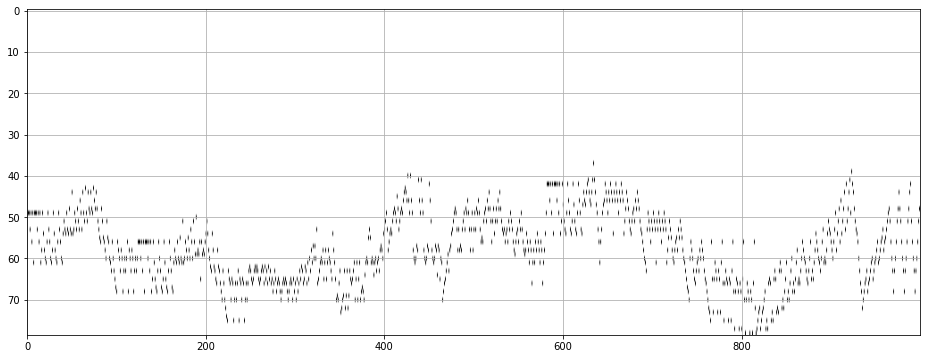

In [ ]:
plt.figure(figsize=(16, 6))
plt.imshow(X_list[2].T, aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)

## Data conversion for the training of language model

For each example/sequence and each possible starting note in this example/sequence, we create two sequences
- an input sequence: 
  - which contains a sub-sequence of length ```sequence_length```;  this sub-sequence range from the note $t$ to the note $t+sequence\_length-1$
- an output sequence:
  - which contains the following note to be predicted, the one at position $t+sequence\_length$

The training is therefore performed by giving to the model a set of sequences as input and asking the network to predict each time the note that should come right after this sequence.

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_RNN_02.png">


In [ ]:
X_train_list = []
y_train_list = []

if student:
    # --- START CODE HERE (01)
    for j in range(len(X_list)):
        for i in range(len(X_list[j]) - sequence_length):
            X_train_list.append(X_list[j][i:i+sequence_length])
            y_train_list.append(X_list[j][i+sequence_length])
    # --- END CODE HERE

X_train = np.asarray(X_train_list)
y_train = np.asarray(y_train_list)

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

X_train.shape: (23781, 20, 79)
y_train.shape: (23781, 79)


# Training the language model

The language model will be learned by training an RNN with input `X_train` and output `Y_train`:  for each of the examples of sequences, we give to the network a sequence of notes of `sequence_length` duration, and ask the network to predict the following note of each sequence.

The network will have the following structure
- (1a) a layer of `LSTM` with $n_a$=256
- (1b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (2a) a layer of `LSTM` with $n_a$=256
- (2b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (3) a layer of `LSTM` with $n_a$=256
- (4a) a layer of `Dense` with 256 units
- (4b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (5) a layer of `Dense` with a `softmax` activation which predict the probability of each of the $n_x$ notes as output

## Returning the hidden states at each time of an LSTM cell

Note that when we stack one LSTM layer on top of a second LSTM layer (deep-RNN), we need to tell the first LSTM to output its hidden states at each time $t$. This is done by the option `return_sequences=True` that has to be given as parameter to the LSTM on top of the other one.
This is the case for (1a) and (2a).

However, since we are only interrested in the last hidden state of the third LSTM (since we are only interrest in its prediction at time $T_x$), we give the option `return_sequences=False` (which is the default behaviour) for the third LSTM.
This is the case for (3).

In [ ]:
# --- Create the model
K.clear_session()

if student:
    model = Sequential()
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.3)) 
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.3)) 
    model.add(LSTM(256, return_sequences=False))
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(n_x, activation='softmax')) 


In [ ]:
# --- Compile and fit the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=64)


Epoch 1/10
372/372 [==============================] - 23s 32ms/step - loss: 2.9280 - accuracy: 0.1193
Epoch 2/10
372/372 [==============================] - 11s 29ms/step - loss: 2.6064 - accuracy: 0.1655
Epoch 3/10
372/372 [==============================] - 11s 29ms/step - loss: 2.5260 - accuracy: 0.1883
Epoch 4/10
372/372 [==============================] - 11s 29ms/step - loss: 2.4565 - accuracy: 0.2232
Epoch 5/10
372/372 [==============================] - 11s 29ms/step - loss: 2.3648 - accuracy: 0.2684
Epoch 6/10
372/372 [==============================] - 11s 29ms/step - loss: 2.2506 - accuracy: 0.3108
Epoch 7/10
372/372 [==============================] - 11s 29ms/step - loss: 2.1251 - accuracy: 0.3506
Epoch 8/10
372/372 [==============================] - 11s 29ms/step - loss: 1.9931 - accuracy: 0.3896
Epoch 9/10
372/372 [==============================] - 11s 29ms/step - loss: 1.8484 - accuracy: 0.4343
Epoch 10/10
372/372 [==============================] - 11s 29ms/step - loss: 1.675

In [ ]:

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 256)           344064    
_________________________________________________________________
dropout (Dropout)            (None, 20, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 256)           525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

# Generating a new sequence from sampling the language model

To generate a new sequence from the language model, we simply give it as input a random sequence of duration ```sequence_length```and ask the trained network to predict the output (using ```model.predict```). 

The output of the network is a vector of probability of dimension $n_x$ which represents the probability of each note to be the next note of the melody given as input.

From this vector, we select the note which has the maximum probability.

We then concatenate this new note (its one-hot-encoding representation) at the end of the input sequence.
We finally remove the first element of the input sequence to keep its duration constant (```sequence_length```).

Instead of providing a random sequence as input, we rather randomly select one sequence out of the 23.781 sequences used for training.

- The ```pattern``` variable is the ```list``` of init notes to which we progressively append the new generated notes by the model.
- The ```prediction``` variable is a ```list``` which stores the softmax probability vector (a numpy array) corresponding to each generation time.


In [ ]:
# --- Select a random starting pattern
start = np.random.randint(0, len(X_train_list)-1)
pattern = X_train[start]
print(start)
print(pattern.shape)
print(np.expand_dims(pattern, 0).shape)

19049
(20, 79)
(1, 20, 79)


In [ ]:
# --- note_l: is the list of notes (integer number) over time
note_l = []
# --- prediction_l: is the list of output-vectors (float numbers \in [0,1]) of the network over time
prediction_l = []
# --- Generate T_y_generated notes
for note_index in range(T_y_generated):
    if student:
        # added intermediate patterns to avoid repetition of songs
        if note_index%(T_y_generated//100):
            start = np.random.randint(0, len(X_train_list)-1)
            pattern = X_train[start]

        prediction = model.predict(np.expand_dims(pattern, 0))
        #print(prediction)
        note_ohe = np.zeros(n_x)
        note_ohe[np.argmax(prediction)+1] = 1
        prediction_l.append([note_ohe])
       
        for i in range(sequence_length-1):
            pattern[i] = pattern[i+1]
        pattern[i] = prediction
        note_l.append(np.argmax(prediction)+1)


### Display the generated sequence

[55, 52, 52, 57, 57, 59, 59, 52, 52, 51, 51, 59, 54, 53, 53, 62, 62, 50, 53, 53, 50, 58, 58, 52, 52, 58, 58, 51, 55, 55, 55, 43, 52, 47, 50, 54, 54, 57, 57, 45, 54, 76, 76, 57, 57, 53, 53, 57, 59, 62, 62, 56, 59, 55, 55, 57, 60, 48, 48, 51, 51, 64, 64, 60, 57, 50, 54, 62, 66, 50, 50, 60, 55, 60, 59, 60, 52, 53, 53, 60, 58, 71, 64, 53, 55, 51, 51, 57, 54, 62, 62, 57, 49, 57, 66, 50, 50, 53, 52, 43, 48, 51, 39, 53, 48, 52, 56, 62, 62, 55, 53, 55, 55, 47, 48, 52, 52, 52, 52, 51, 55, 53, 53, 53, 55, 57, 57, 53, 53, 52, 50, 50, 50, 55, 52, 61, 59, 57, 55, 48, 51, 58, 58, 57, 57, 61, 62, 55, 55, 61, 61, 48, 48, 53, 53, 57, 61, 58, 58, 62, 59, 47, 45, 65, 62, 50, 50, 50, 53, 62, 66, 58, 55, 61, 61, 50, 50, 45, 43, 76, 76, 53, 53, 59, 59, 52, 47, 50, 46, 52, 52, 60, 59, 53, 46, 62, 62, 62, 58, 51]


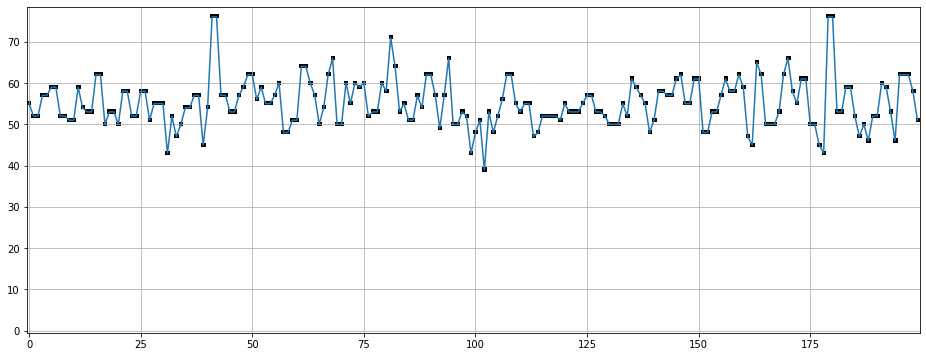

In [ ]:
print(note_l)

plt.figure(figsize=(16, 6))
plt.imshow(np.asarray(prediction_l)[:,0,:].T, aspect='auto', origin='lower')
plt.plot(note_l)
plt.set_cmap('gray_r')
plt.grid(True)

### Create a MIDI file and an audio file which correspond to the generated sequence

Once the new sequence has been generated (```note_l```) we transform it to a new MIDI file and perform (a very cheap) rendering of it in an audio file.

In [ ]:
new_midi_data = pretty_midi.PrettyMIDI()
cello_program = pretty_midi.instrument_name_to_program('Cello')
cello = pretty_midi.Instrument(program=cello_program)
time = 0
step = 0.3
for note_number in note_l:
    myNote = pretty_midi.Note(velocity=100, pitch=note_number, start=time, end=time+step)
    cello.notes.append(myNote)
    time += step
new_midi_data.instruments.append(cello)
new_midi_data.write('output.mid')

In [ ]:
%matplotlib inline

audio_data = new_midi_data.synthesize(fs=44100)
IPython.display.Audio(audio_data, rate=44100)

## Question 1)

Que se passe-t'il si on remplace la cellule LSTM par une cellule RNNsimple ?

**Réponse (en-dessous)** (1 points)

The main difference is that the simpleRNN concatenates the input and the previous hidden state:
$$h^t = g(W_{hh}h^{t-1}+W_{hx}x^t+b_h)$$
$$y^t=h^t$$

But in the LSTM we have different weight matrices which are applied to the both before passing them to 4 internal neural networks in the LSTM cell and it has information from previous states.

This gives the LSTM 4 times the number of trainable parameters and makes the result better for one single layer.

Also, there is a risk of having a vanishing gradient and therefore of being unable to learn in the long term.

## Question 2) 

Que se passe-t'il si l'on raccourci la longueur des séquences utilisées pour l'entrainement ? Comment palier à cet effet ?

**Réponse (en-dessous)** (1 points)

We would have results that are more simplistic, because if we lower the dimention of the pattern we also lower the number of possible subsequential notes that the pattern generates.

This would create a sequence of notes that fall into a pattern and converges to a single note more easily.

To remedy that, one can reinject the value of the hidden state and of the memory at the following moment. To do this, you must pass the stateful parameter to True in the LSTM layers.

Another way we could avoid these problems when lowering the lenght of the pattern, would be to reinitialise the pattern with intermediary ones $(pattern = X_train[intermediary])$ from the X_train set, so that we are able to avoid the convergence of allways reusing the [lenght-1] values of the previous pattern.

## Question 3) 
Comment pourrait-on rendre le système ```polyphonique``` (plusieurs notes jouées simultanément par le même instrument) ? pour l'entrainement ? pour la génération ?

**Réponse (en-dessous)** (2 points)

### Solution 1:
We turn the problem in to a many to many problem where we predict the next $n$ notes using the previous $n$ notes, where $n$ is the number of different simultanious instruments.

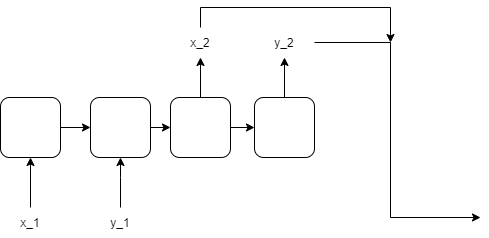

### Solution 2:
We could use the same system as before but now we would create a one hot vector that 
- an input sequence: 
  - which contains a sub-sequence of length ```sequence_length```;  this sub-sequence range from the note $t$ to the note $t+sequence\_length-1$. But the difference now would be that the sequence would be the concatenation of all the instruments:
  $$x^{<1>} = [x^{<1>}_{i_0}|x^{<1>}_{i_1}|...|x^{<1>}_{i_n}]$$
- an output sequence:
  - which contains the following note to be predicted for every instrument $i_n$, the one at position $t+sequence\_length$
  
By generalizing the one-hot-encoding to several values 1, by replacing the softmax by sigmoids (multi-label) and the cross-entropy by the sum of the binary cross-entropy.

The training is therefore performed by giving to the model a set of sequences as input and asking the network to predict each time the note that should come right after this sequence.

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_RNN_02.png">


## Question 4) 

Nous avons utilisé une procédure simplifiée pour entrainer le modèle de language musical, en transformant l'apprentissage en un problème Many-To-one. Expliquez ? Comment entraine-t'on habituellement un modèle de language avec un RNN ? Quel en serait l'avantage ?

**Réponse (en-dessous)** (2 points)

In this example we used the many to one approach by using several previous notes to generate a single sequential note.

Usually we train a language model using a one to many setting by predicting the next word using its previous one. It is a more efficient method and if we use LSTMs that have long short-term memories, we should still be able to consider previous layers.